# Hans 2024 data

Should probably formalize this as a Luigi or Airflow pipeline, but for now let's get everything set up interactively in notebooks so we can plot along the way.

## TODO:
1. Fix inclusion of too short fragments in scoring, or allow it on purpose.

    Let's allow it on purpose - we can always filter the short fragments out later or even train multiple classifiers for different length ranges. I would like to be able to give a score for short fragments, even if it come with a caveat about reduced accuracy on shorter text. I just know people are going to want to use this thing on tweets...

2. Set longer length limit for Falcon, possibly using sequential device map or even CPU.
    
    Some complexity here - thinking maybe we should be using the 'auto' device map, it can handle longer sequences and works just as fast as a single K80, but that implies we have to keep loading and reloading the base and instruction tuned models. We could batch - do the reader calculations for a set of fragments and then switch models to do the writer calculations. Also, should probably set the length limit to ~1000 words. Given the length distribution of texts in the original dataset, that's pretty much the high end of the synthetic texts, but it's not very long for the human. Need to be careful how we sample lengths - want our length distributions to end up similar.
    
3. ~~Score both matched fragments from row in Hans data. More data is better!~~
4. ~~Shuffle data before train-test split such that training data is not mostly or all from the same sub-dataset.~~

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import configuration as config

/mnt/arkk/llm_detector/classifier


Load the scored text fragment data from the Hans 2024 corpus.

In [2]:
# Load the data
data_df = pd.read_json(f'{config.HANS_DATA_PATH}/ppl_v2.json')

# Replace and remove string 'OOM' and 'NAN' values
data_df.replace('NAN', np.nan, inplace = True)
data_df.replace('OOM', np.nan, inplace = True)
data_df.dropna(inplace = True)

# # Fix some d-types
# dataframe = dataframe.astype({
#     'Fragment': int,
#     'Fragment length (tokens)': int,
#     'Reader peak memory (GB)': float,
#     'Writer peak memory (GB)': float,
#     'Perplexity': float,
#     'Cross-perplexity': float,
#     'Perplexity ratio score': float
# })

# # get rid of some unnecessary columns
# dataframe.drop([
#     'Fragment', 
#     'Reader peak memory (GB)', 
#     'Writer peak memory (GB)'
# ], axis = 1, inplace = True)

# Shuffle the deck, resetting the index
data_df = data_df.sample(frac = 1).reset_index(drop = True)
data_df.reset_index(inplace = True, drop = True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Fragment length (words)         184 non-null    int64  
 1   Fragment length (tokens)        184 non-null    int64  
 2   Dataset                         184 non-null    object 
 3   Source                          184 non-null    object 
 4   String                          184 non-null    object 
 5   Reversed string                 184 non-null    object 
 6   Perplexity                      184 non-null    float64
 7   Reverse perplexity              184 non-null    float64
 8   Cross-perplexity                184 non-null    float64
 9   Reverse cross-perplexity        184 non-null    float64
 10  Perplexity ratio score          184 non-null    float64
 11  Reverse perplexity ratio score  184 non-null    float64
 12  Reader time (seconds)           184 

Take a quick look for sanity...

In [3]:
# Get human and synthetic fragments
human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

# Get the size of each
human_fragment_count = len(human_fragments)
synthetic_fragment_count = len(synthetic_fragments)

# And the percent synthetic
percent_synthetic = round((synthetic_fragment_count / (synthetic_fragment_count + human_fragment_count)) * 100, 1)

print(f'Have {human_fragment_count} human text fragments and {synthetic_fragment_count} synthetic fragments.')
print(f'Dataset is {percent_synthetic}% synthetic fragments.')

Have 92 human text fragments and 92 synthetic fragments.
Dataset is 50.0% synthetic fragments.


In [4]:
data_df.head()

,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Reversed string,Perplexity,Reverse perplexity,Cross-perplexity,Reverse cross-perplexity,Perplexity ratio score,Reverse perplexity ratio score,Reader time (seconds),Writer time (seconds),Reader peak memory (GB),Writer peak memory (GB)
0,298,499,cc_news,synthetic,"$54.40, for a total value of $298,532.80. Fol...",in company the for target price $68.00 a set a...,0.767181,3.924311,0.855776,4.337095,0.896474,0.904825,43.081522,43.265766,92.696576,87.754752
1,150,267,cc_news,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,"quarter, the for (EPS) share per earnings $0.6...",0.968972,4.087437,1.023171,4.383107,0.947028,0.932543,23.274783,23.528820,90.920960,87.754752
2,212,371,cc_news,synthetic,"$54.40, for a total value of $298,532.80. Fol...",7.7% down was revenue Company’s Fuller B. H. E...,0.898293,3.977613,0.987127,4.298888,0.910008,0.925265,31.946495,31.935486,91.645952,87.754752
3,216,375,cc_news,synthetic,"$54.40, for a total value of $298,532.80. Fol...",same the to compared 7.7% down was revenue Com...,0.892277,3.970661,0.978503,4.423925,0.911879,0.897543,32.155303,32.238172,91.688960,87.754752
4,211,370,cc_news,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,year.\nThe fiscal current the for share per ea...,0.893255,4.082052,0.928156,4.342527,0.962397,0.940018,31.873766,31.897319,91.678720,87.754752


In [5]:
data_df.tail()

,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Reversed string,Perplexity,Reverse perplexity,Cross-perplexity,Reverse cross-perplexity,Perplexity ratio score,Reverse perplexity ratio score,Reader time (seconds),Writer time (seconds),Reader peak memory (GB),Writer peak memory (GB)
179,172,306,cc_news,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,"analysts’ to compared quarter, the during mill...",0.933770,4.151607,0.968521,4.411078,0.964119,0.941177,26.567721,26.718035,91.217920,87.754752
180,183,322,cc_news,synthetic,"$54.40, for a total value of $298,532.80. Fol...",the for million $534.70 of revenue had company...,0.945760,3.976697,1.021858,4.357921,0.925530,0.912522,27.907289,27.955519,91.277312,87.754752
181,269,453,cc_news,synthetic,"$54.40, for a total value of $298,532.80. Fol...",on note research a in rating “strong-buy” a to...,0.801795,4.036827,0.896924,4.452910,0.893939,0.906559,39.157038,39.283236,92.350464,87.754752
182,136,242,cc_news,synthetic,"$54.40, for a total value of $298,532.80. Fol...","26th. July Wednesday, on results earnings quar...",1.049342,4.126003,1.135914,4.369622,0.923786,0.944247,21.243250,21.456790,90.595328,87.640064
183,182,323,cc_news,human,H. B. Fuller Company (NYSE:FUL) VP Traci L. Je...,net a had Fuller B. H. million. $553.66 of exp...,0.920192,4.104534,0.953224,4.398124,0.965347,0.933247,27.964678,27.995459,91.332608,87.754752


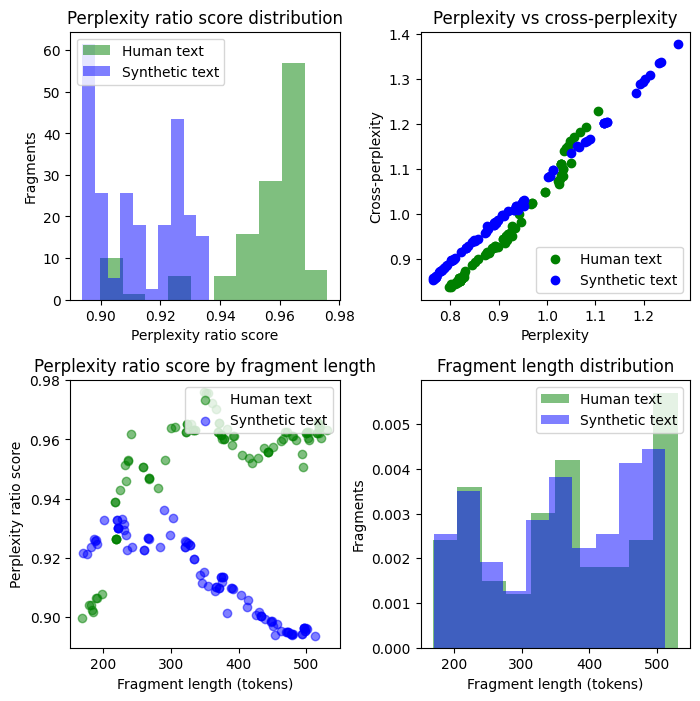

In [6]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (tokens)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'upper right')
axs[1,0].set_xlabel('Fragment length (tokens)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (tokens)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (tokens)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (tokens)')
axs[1,1].set_ylabel('Fragments')

plt.show()

Something strange in the fragment length vs perplexity ratio score plot - the minimum fragment length should be 50 words? Not sure what is going on... let's take a closer look.

In [7]:
short_fragments = human_fragments[human_fragments['Fragment length (tokens)'] < 10]
short_fragments.head()

,Fragment length (words),Fragment length (tokens),Dataset,Source,String,Reversed string,Perplexity,Reverse perplexity,Cross-perplexity,Reverse cross-perplexity,Perplexity ratio score,Reverse perplexity ratio score,Reader time (seconds),Writer time (seconds),Reader peak memory (GB),Writer peak memory (GB)


Yeah, looks like we have some weird stuff - apparently the extra ends of sentences get used? This could be a problem with how we did the sampling from the larger blocks of text contained in the Hans corpus. We don't have time to go back and fix it, but we can prevent those scores from being carried forward at this step. Let's threshold the length before we save.

Yeah, side note, found it. From perplexity_ratio.py in the benchmarking functions (line 147):

```text
    # If the slice length is greater than the
    # length of the input tokens, use all of
    # them
    if slice_length > total_length:
        slice_length = total_length
```

Also, bad terminological specificity here - we are actually talking about words.... not tokens.

In [8]:
data_df = data_df[data_df['Fragment length (tokens)'] > 50]

human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

OK - plot again just for sanity check.

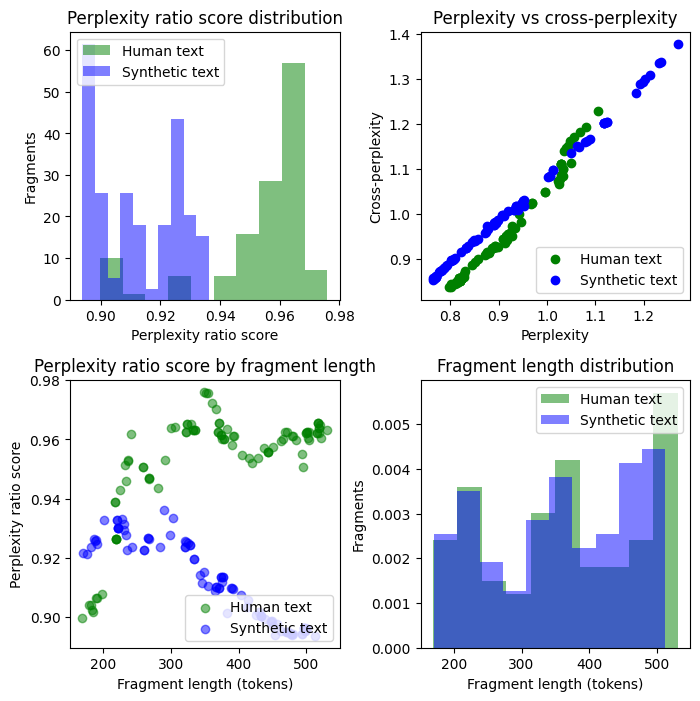

In [9]:
# Set up a 2 x 2 figure for some diagnostic plots
fig, axs = plt.subplots(
    2,
    2,
    figsize = (8, 8),
    gridspec_kw = {'wspace':0.3, 'hspace':0.3}
)

# Plot distribution of perplexity ratio scores
axs[0,0].set_title('Perplexity ratio score distribution')
axs[0,0].hist(human_fragments['Perplexity ratio score'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[0,0].hist(synthetic_fragments['Perplexity ratio score'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[0,0].legend(loc = 'upper left')
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Fragments')

# Scatter plot of perplexity vs cross-perplexity
axs[0,1].set_title('Perplexity vs cross-perplexity')
axs[0,1].scatter(human_fragments['Perplexity'], human_fragments['Cross-perplexity'], c = 'green', label = 'Human text')
axs[0,1].scatter(synthetic_fragments['Perplexity'], synthetic_fragments['Cross-perplexity'], c = 'blue', label = 'Synthetic text')
axs[0,1].legend(loc = 'lower right')
axs[0,1].set_xlabel('Perplexity')
axs[0,1].set_ylabel('Cross-perplexity')

# Scatter plot of perplexity ratio score as a function of the
# the text fragment length
axs[1,0].set_title('Perplexity ratio score by fragment length')
axs[1,0].scatter(human_fragments['Fragment length (tokens)'], human_fragments['Perplexity ratio score'], c = 'green', alpha = 0.5, label = 'Human text')
axs[1,0].scatter(synthetic_fragments['Fragment length (tokens)'], synthetic_fragments['Perplexity ratio score'], c = 'blue', alpha = 0.5, label = 'Synthetic text')
axs[1,0].legend(loc = 'lower right')
axs[1,0].set_xlabel('Fragment length (tokens)')
axs[1,0].set_ylabel('Perplexity ratio score')

# Plot length distributions for human and synthetic text fragments
axs[1,1].set_title('Fragment length distribution')
axs[1,1].hist(human_fragments['Fragment length (tokens)'], density = True, facecolor = 'green', label = 'Human text', alpha = 0.5)
axs[1,1].hist(synthetic_fragments['Fragment length (tokens)'], density = True, facecolor = 'blue', label = 'Synthetic text', alpha = 0.5)
axs[1,1].legend(loc = 'upper right')
axs[1,1].set_xlabel('Fragment length (tokens)')
axs[1,1].set_ylabel('Fragments')

plt.show()

OK, good, looks good, actually much better. Let's clip those high outliers on the perplexity/cross perplexity plot.

In [10]:
data_df = data_df[(data_df['Perplexity'] < 6) & (data_df['Cross-perplexity'] < 6)]

human_fragments = data_df[data_df['Source'] == 'human']
synthetic_fragments = data_df[data_df['Source'] == 'synthetic']

In [11]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_DATA

with open(output_file, 'w') as file:
    file.write(data_df.to_json())

Next, let's split the data in to training and testing subsets. This way as we do the feature engineering steps we are not leaking data.

In [12]:
training_df = data_df.sample(frac = 0.8, random_state = 42)
testing_df = data_df.drop(training_df.index)

training_df.reset_index(inplace = True, drop = True)
testing_df.reset_index(inplace = True, drop = True)

print(f'Have {len(training_df)} training examples')
print(f'Have {len(testing_df)} testing examples')
print()
testing_df.info()

Have 147 training examples
Have 37 testing examples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Fragment length (words)         37 non-null     int64  
 1   Fragment length (tokens)        37 non-null     int64  
 2   Dataset                         37 non-null     object 
 3   Source                          37 non-null     object 
 4   String                          37 non-null     object 
 5   Reversed string                 37 non-null     object 
 6   Perplexity                      37 non-null     float64
 7   Reverse perplexity              37 non-null     float64
 8   Cross-perplexity                37 non-null     float64
 9   Reverse cross-perplexity        37 non-null     float64
 10  Perplexity ratio score          37 non-null     float64
 11  Reverse perplexity ratio score  37 non-null   

And finally, save the split data for future use.

In [13]:
# Save testing data
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA

with open(output_file, 'w') as file:
    file.write(training_df.to_json())

# Save testing data
output_file = config.COMBINED_SCORED_HANS_TESTING_DATA

with open(output_file, 'w') as file:
    file.write(testing_df.to_json())